##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

In [2]:
import numpy as np

import tensorflow as tf

In [3]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/files/IMDB Dataset.csv')

# convert labels to binary (positive=1, negative=0)
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# split into train and test sets (80/20 split)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_df['review'].values, train_df['sentiment'].values))
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_df['review'].values, test_df['sentiment'].values))

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'That\'s what I kept asking myself during the many fights, screaming matches, swearing and general mayhem that permeate the 84 minutes. The comparisons also stand up when you think of the one-dimensional characters, who have so little depth that it is virtually impossible to care what happens to them. They are just badly written cyphers for the director to hang his multicultural beliefs on, a topic that has been done much better in other dramas both on TV and the cinema.<br /><br />I must confess, I\'m not really one for spotting bad performances during a film, but it must be said that Nichola Burley (as the heroine\'s slutty best friend) and Wasim Zakir (as the nasty, bullying brother) were absolutely terrible. I don\'t know what acting school they graduated from, but if I was them I\'d apply for a full refund post haste. Only Samina Awan in the lead role manages to impress in a cast of so-called British talent that we\'ll probably never hear from again. At least, that\'s the 

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'I\'ll keep the review of this program as short as possible. Skip it. Low budget, not funny, lousy script. Acting not quite as bad as the writing, but still bad. That\'s all you need to know, but I will continue for the sake of writing more than necessary.<br /><br />This is a film with three segments, each one parodying some other type of movie. A MUCH funnier film with this same exact idea is "Movie Movie," with George C. Scott. Very obscure, but worth searching out. MM parodied films of the 1930\'s, and did it with elegance, precision and dry wit.<br /><br />This movie did not. It parodies three types of films, supposedly from the late 70\'s, early 80\'s era, only it is parodying films I\'ve (almost) never heard of. The first is, I guess, a parody of "Kramer Vs. Kramer," in a way. Peter Reigert does his best with a dirt poor script. The second is a parody, of, I don\'t know what...a Danielle Steele novel? I mean, you might see a story like this on Lifetime TV, but in a mov

## Create the text encoder

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[534, 378,   2, ...,   0,   0,   0],
       [455,  63,  63, ...,   0,   0,   0],
       [ 11,  20,   1, ...,   0,   0,   0]])

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I\'ll keep the review of this program as short as possible. Skip it. Low budget, not funny, lousy script. Acting not quite as bad as the writing, but still bad. That\'s all you need to know, but I will continue for the sake of writing more than necessary.<br /><br />This is a film with three segments, each one parodying some other type of movie. A MUCH funnier film with this same exact idea is "Movie Movie," with George C. Scott. Very obscure, but worth searching out. MM parodied films of the 1930\'s, and did it with elegance, precision and dry wit.<br /><br />This movie did not. It parodies three types of films, supposedly from the late 70\'s, early 80\'s era, only it is parodying films I\'ve (almost) never heard of. The first is, I guess, a parody of "Kramer Vs. Kramer," in a way. Peter Reigert does his best with a dirt poor script. The second is a parody, of, I don\'t know what...a Danielle Steele novel? I mean, you might see a story like this on Lifetime TV, but in a m

## Create the model

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(tf.constant([sample_text]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
[0.0002136]


In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(tf.constant([sample_text, padding]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
[0.0002136]


In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [18]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 56ms/step - accuracy: 0.5496 - loss: 0.6499 - val_accuracy: 0.8234 - val_loss: 0.3658
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.8386 - loss: 0.3594 - val_accuracy: 0.8562 - val_loss: 0.3289
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.8568 - loss: 0.3281 - val_accuracy: 0.8562 - val_loss: 0.3220
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.8632 - loss: 0.3152 - val_accuracy: 0.8630 - val_loss: 0.3396
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.8669 - loss: 0.3085 - val_accuracy: 0.7896 - val_loss: 0.3730
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.8644 - loss: 0.3127 - val_accuracy: 0.8609 - val_loss: 0.3446
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.8671 - loss: 0.3038 - val_accuracy: 0.8578 - val_loss: 0.3173
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.8714 - loss: 0.3001 - 

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8516 - loss: 0.3301
Test Loss: 0.3247683048248291
Test Accuracy: 0.8543999791145325


(0.0, 0.5685868009924888)

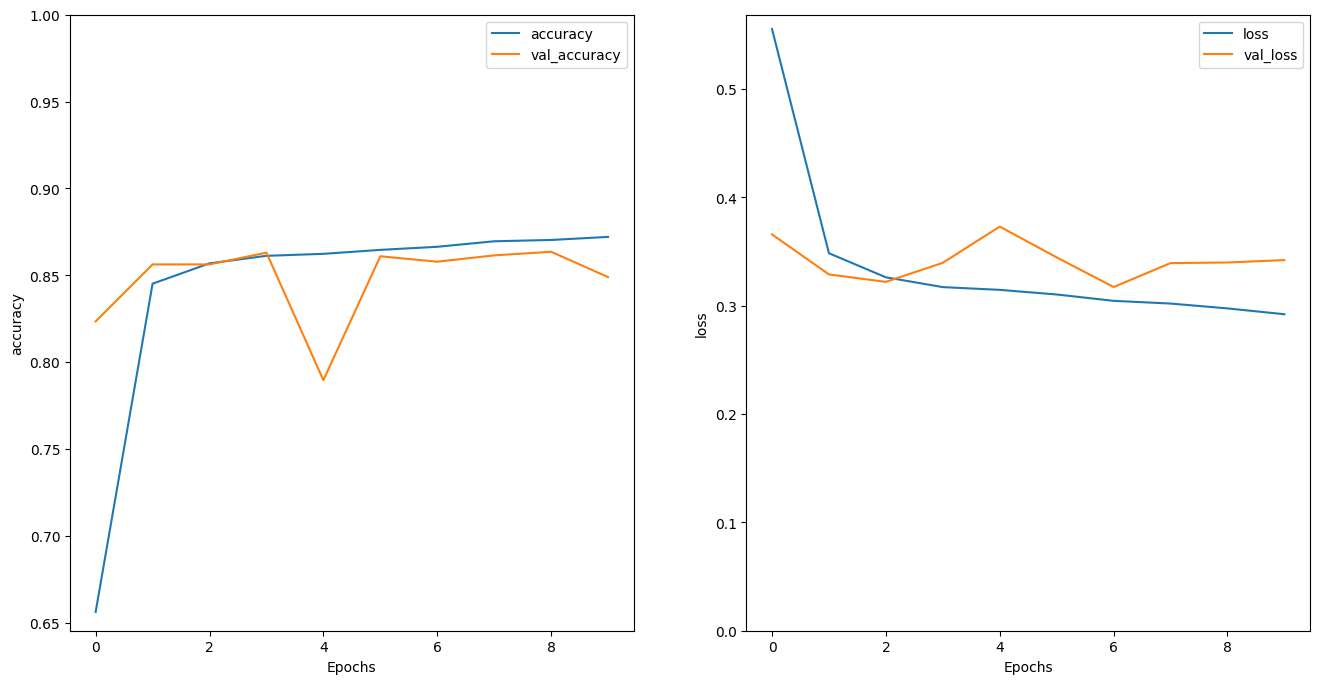

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(tf.constant([sample_text]))
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
[[0.17688054]]


In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 130ms/step - accuracy: 0.5555 - loss: 0.6543 - val_accuracy: 0.8297 - val_loss: 0.3769
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 127ms/step - accuracy: 0.8382 - loss: 0.3724 - val_accuracy: 0.8557 - val_loss: 0.3229
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 127ms/step - accuracy: 0.8581 - loss: 0.3283 - val_accuracy: 0.8568 - val_loss: 0.3272
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 126ms/step - accuracy: 0.8604 - loss: 0.3189 - val_accuracy: 0.8562 - val_loss: 0.3551
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 127ms/step - accuracy: 0.8677 - loss: 0.3077 - val_accuracy: 0.8661 - val_loss: 0.3285
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 126ms/step - accuracy: 0.8676 - loss: 0.3059 - val_accuracy: 0.8557 - val_loss: 0.3123
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 125ms/step - accuracy: 0.8706 - loss: 0.2999 - val_accuracy: 0.8682 - val_loss: 0.3350
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 127ms/step - accuracy: 0.8702 - loss: 0

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.8190 - loss: 0.3369
Test Loss: 0.3341846168041229
Test Accuracy: 0.817799985408783


In [26]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(tf.constant([sample_text]))
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
[[-1.9118404]]


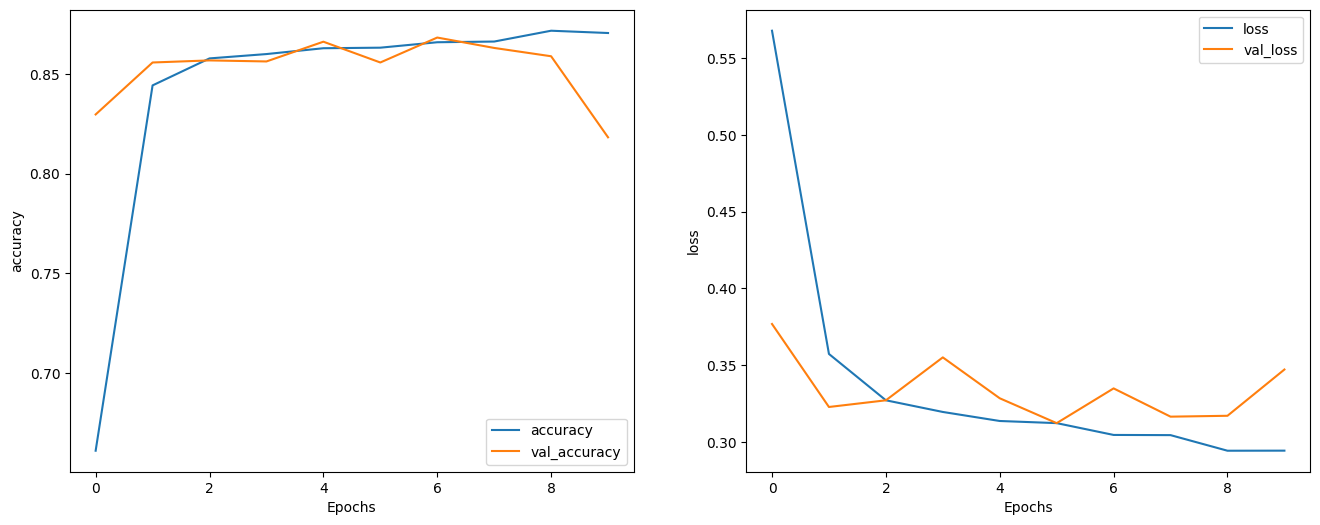

In [27]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')